[a) pinv] MSE: 0.014531, W shape: (12, 1)


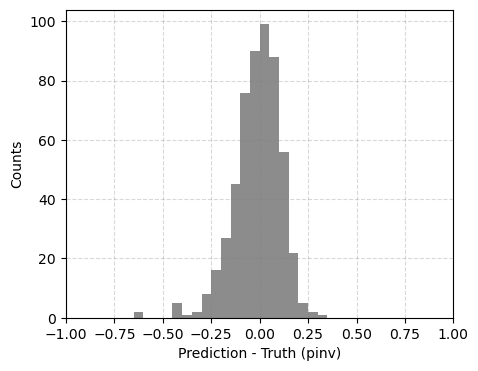

In [1]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import pandas as pd

from tqdm import tqdm  

# =============================================================================
# Read the data
# =============================================================================
data = np.array(pd.read_csv("Data.csv"))
Y = data[:, 0].reshape((-1, 1))  # (N, 1)
X = data[:, 1:]                  # (N, D)

# =============================================================================
# Scaling (min-max normalization to [0, 1])
# =============================================================================
for i in range(X.shape[1]):
    col_min = np.amin(X[:, i])
    col_max = np.amax(X[:, i])
    # Avoid divide by zero in case a feature is constant
    if col_max == col_min:
        X[:, i] = 0.0
    else:
        X[:, i] = (X[:, i] - col_min) / (col_max - col_min)

Y_min, Y_max = np.amin(Y), np.amax(Y)
if Y_max == Y_min:
    Y = np.zeros_like(Y)
else:
    Y = (Y - Y_min) / (Y_max - Y_min)

# -----------------------------------------------------------------------------
# Optional: Alternative scaling (commented out)
# You can try z-score standardization, which often works better for least squares:
# X = (X - X.mean(axis=0)) / (X.std(axis=0) + 1e-12)
# Y = (Y - Y.mean()) / (Y.std() + 1e-12)
# -----------------------------------------------------------------------------


# =============================================================================
# a) Calculating the Pseudo-Inverse directly
#    Solve: min ||XW - Y||_2
# =============================================================================

# TODO: Solve the problem by calculating the pseudo inverse using numpy.linalg.pinv()
X_pinv_np = np.linalg.pinv(X)  # Moore–Penrose pseudo-inverse via NumPy

# TODO: Enter your prediction variables
# Least-squares solution W = X^+ Y
W_np = X_pinv_np @ Y           # (D, 1)
Y_pred_np = X @ W_np           # (N, 1)

# Residuals (Prediction - Truth); you can use absolute error instead if desired.
E_np = np.power(Y_pred_np - Y, 1)   # same as (Y_pred_np - Y)

# Diagnostics
mse_np = np.mean((Y_pred_np - Y) ** 2)
print(f"[a) pinv] MSE: {mse_np:.6f}, W shape: {W_np.shape}")

fig, ax = plt.subplots(figsize=(5, 4))
ax.hist(E_np, bins=40, alpha=0.9, histtype='bar', ec='black',
        range=[-1, 1], color="grey")
ax.set_xlabel("Prediction - Truth (pinv)")
ax.set_ylabel("Counts")
ax.set_xlim([-1, 1])
ax.grid(color='gray', linestyle='dashed', alpha=0.3)
plt.show()


# a) Calculating the Pseudo-Inverse directly
Use numpy to calculate the Moore-Penrose pseudo-inverse and solve 

$min||XW-Y||_2$

[b) SVD]  MSE: 0.014531, W shape: (12, 1)


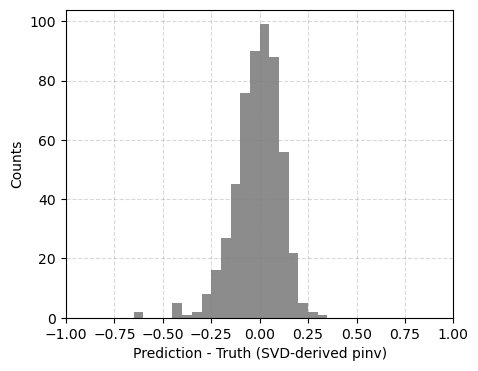

In [3]:
#=============================================================================
# b) Calculating the Pseudo-Inverse by deriving the SVD
# =============================================================================

# TODO: Solve the problem by calculating the pseudo inverse using the SVD.
#       Use the SVD components to derive the pseudo inverse.

# SVD: X = U Σ V^T, with Σ = diag(s)
U, s, Vt = np.linalg.svd(X, full_matrices=False)

# Build Σ^+ (reciprocal of non-zero singular values); use a tolerance
# This mimics the behavior of np.linalg.pinv with a small rcond
tol = np.finfo(s.dtype).eps * max(X.shape) * s[0] if s.size > 0 else 0.0
s_inv = np.array([1/si if si > tol else 0.0 for si in s])

Sigma_plus = np.diag(s_inv)

# Moore–Penrose pseudo-inverse: X^+ = V Σ^+ U^T
X_pinv_svd = Vt.T @ Sigma_plus @ U.T

# Least-squares solution W = X^+ Y from SVD
W_svd = X_pinv_svd @ Y
Y_pred_svd = X @ W_svd
E_svd = np.power(Y_pred_svd - Y, 1)

mse_svd = np.mean((Y_pred_svd - Y) ** 2)
print(f"[b) SVD]  MSE: {mse_svd:.6f}, W shape: {W_svd.shape}")

fig, ax = plt.subplots(figsize=(5, 4))
ax.hist(E_svd, bins=40, alpha=0.9, histtype='bar', ec='black',
        range=[-1, 1], color="grey")
ax.set_xlabel("Prediction - Truth (SVD-derived pinv)")
ax.set_ylabel("Counts")
ax.set_xlim([-1, 1])
ax.grid(color='gray', linestyle='dashed', alpha=0.3)
plt.show()


# b) Calculating the Pseudo-Inverse by deriving the SVD

Max absolute difference between pinv and SVD-derived pinv: 2.220446049250e-16
Max |W_np - W_svd|: 1.110223024625e-16
Max |Y_pred_np - Y_pred_svd|: 1.110223024625e-16


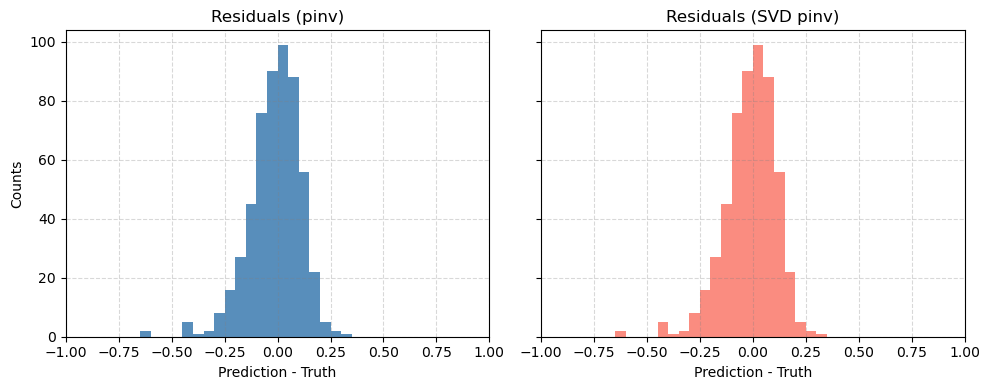

In [5]:

# =============================================================================
# Comparison: pinv vs SVD-derived pseudo-inverse
# =============================================================================

# TODO: compare the results, e.g. np.max(A_1 - A_2)
max_diff_pinv = np.max(np.abs(X_pinv_np - X_pinv_svd))
print(f"Max absolute difference between pinv and SVD-derived pinv: {max_diff_pinv:.12e}")

# TODO: Enter your prediction variables (already done above)
# We'll also compare coefficients and predictions:
max_diff_W = np.max(np.abs(W_np - W_svd))
max_diff_pred = np.max(np.abs(Y_pred_np - Y_pred_svd))
print(f"Max |W_np - W_svd|: {max_diff_W:.12e}")
print(f"Max |Y_pred_np - Y_pred_svd|: {max_diff_pred:.12e}")

# Side-by-side histograms for residuals (optional)
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
axes[0].hist(E_np, bins=40, alpha=0.9, histtype='bar', ec='black',
             range=[-1, 1], color="steelblue")
axes[0].set_title("Residuals (pinv)")
axes[0].set_xlabel("Prediction - Truth")
axes[0].set_xlim([-1, 1])
axes[0].grid(color='gray', linestyle='dashed', alpha=0.3)

axes[1].hist(E_svd, bins=40, alpha=0.9, histtype='bar', ec='black',
             range=[-1, 1], color="salmon")
axes[1].set_title("Residuals (SVD pinv)")
axes[1].set_xlabel("Prediction - Truth")
axes[1].set_xlim([-1, 1])
axes[1].grid(color='gray', linestyle='dashed', alpha=0.3)

axes[0].set_ylabel("Counts")
plt.tight_layout()
